## Da fare
1. Car model classification:
   - entire car images vs **car parts**
   - **specific viewpoint** vs all viewpoints
2. **Car make classification**
3. **Attribute Prediction:**
   - Sum of square loss for continuous attributes
   - Logistic loss for for discrete attributes
   - Trained of the first set and tested on the second 

In [7]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from sklearn.utils.class_weight import compute_class_weight
import importlib
from pathlib import Path
import re

from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d
from torch.nn import SiLU as ReLU
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, Resize
import torch

import utils
import dataset 
import ResNet18_blocks
import ResNet50_blocks
from dataset import indexing_labels, check_unbalance_dataset, ImageDataset
from utils import plot_losses, exponential_moving_average
from ResNet18_blocks import BasicBlock, ResNet18
from ResNet50_blocks import MainPath, IdentityBlock, ConvolutionalBlock, ResNet50
from training_functions import network_training, transforms_train, transforms, FocalLoss, evaluate_network

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [8]:
importlib.reload(utils)
importlib.reload(dataset)
importlib.reload(ResNet18_blocks)
importlib.reload(ResNet50_blocks);

# Neural Network and Deep Learning Project

*Alberto Salvador, Volpi Gaia*



In [23]:
volume_dir = "/mnt/shared_volume/"

In [29]:
! ls /mnt/shared_volume/data/train_test_split/classification

test.txt  test_updated.txt  train.txt  valid.txt


In [11]:
def debug(text, var, debug_mode=True):
    """
    text: the text that preceed the debug message
    var: list of variables whose values are to be displayed
    """
    if debug_mode:
        print("Debug: ", text, var)

## 1. Dataset

In [24]:
label_to_index = indexing_labels(volume_dir+"data/train_test_split/classification/train.txt")
print("Nr of models in the train dataset: ", len(label_to_index))

Nr of models in the train dataset:  431


viewpoint:
- -1 - uncertain
- 1 - front
- 2 - rear
- 3 - side
- 4 - front-side
- 5 - rear-side

In [25]:
viewpoint = None
train_dataset =  ImageDataset(volume_dir +"data", volume_dir + "data/train_test_split/classification/train.txt", label_to_index, transforms_train, viewpoint)
test_dataset =  ImageDataset(volume_dir +"data", volume_dir +"data/train_test_split/classification/test_updated.txt", label_to_index, transforms, viewpoint)
valid_dataset =  ImageDataset(volume_dir +"data", volume_dir +"data/train_test_split/classification/valid.txt", label_to_index, transforms, viewpoint)

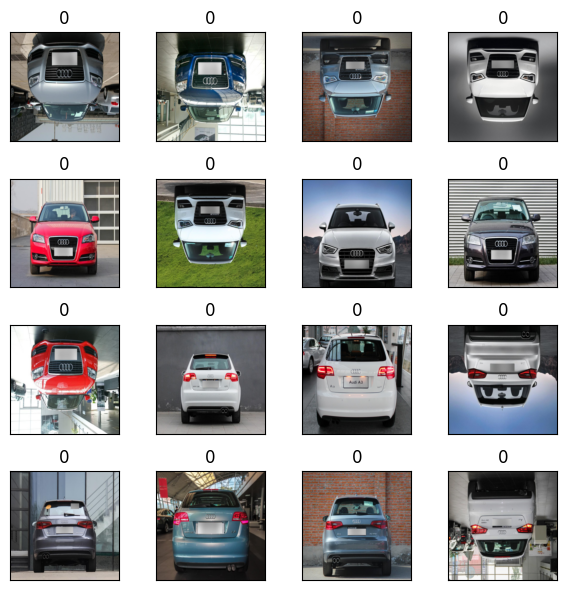

In [26]:
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    axs[i//4][i%4].imshow(train_dataset[i][0].permute(1, 2, 0).numpy())
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"{train_dataset[i][1]}")
plt.tight_layout()

In [15]:
print(f'train dataset: {len(train_dataset)} \ntest dataset: {len(test_dataset)} \nvalid dataset: {len(valid_dataset)}')

train dataset: 16016 
test dataset: 7470 
valid dataset: 7469


In [16]:
# Here we use the Dataloader function from pytorch to opportunely split the dataset in batches and shuffling data
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())

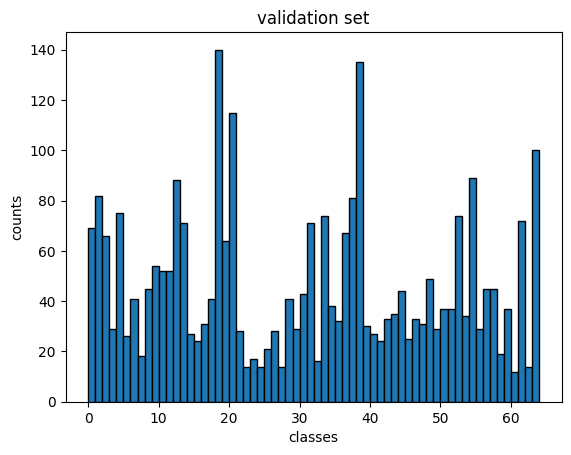

In [27]:
check_unbalance_dataset(valid_dataloader, n_indices=3000, title='validation set')

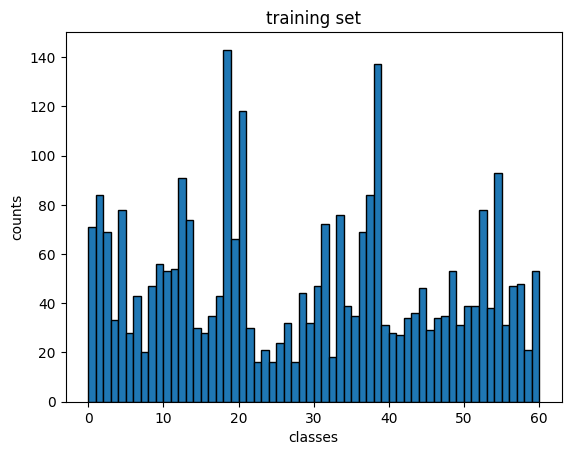

In [25]:
check_unbalance_dataset(train_dataloader, n_indices=3000, title='training set')

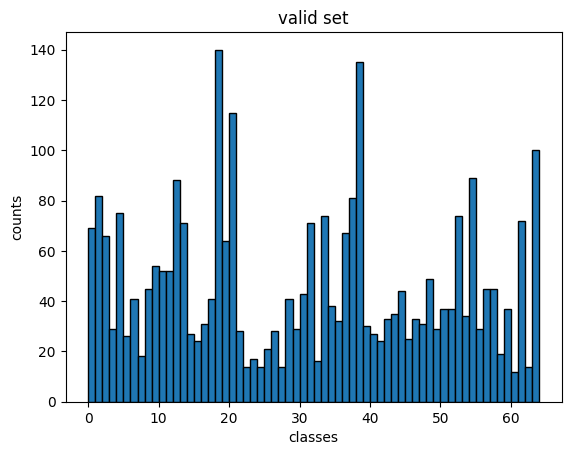

In [26]:
check_unbalance_dataset(valid_dataloader, n_indices=3000, title='valid set')

## 2. ResNet50() architecture

### 2.1 Identity block

The identity block corresponds to the case where the input activation ($a^{[l]}$) has the same dimension as the output activation ($a^{[l+2]}$).
We implement the case in which the skip connection "skips over" 3 hidden layers.

The upper path is the "shortcut path". The lower path is the "main path" with convolutional layers and ReLu activation functions. To speed up training we also add BatchNorm layers.  

Here are the individual steps:

**First component** of main path:
- CONV2D with $F_1$ filters of shape (1, 1), stride of (1, 1), padding "valid".
- BatchNorm, normalizing the 'channels' axis.
- ReLU activation function.

**Second component** of main path:
- CONV2D with $F_2$ filters of shape $(f, f)$, stride of (1, 1), padding "same".
- BatchNorm, normalizing the 'channels' axis.
- ReLU activation function.

**Third component** of main path:
- CONV2D with $F_3$ filters of shape (1, 1), stride of (1, 1), padding "valid".
- BatchNorm, normalizing the 'channels' axis.

**Final step**:
- Add together the `X_input` and the output from the 3rd layer `X` (shortcut).
- ReLU activation function.
![Alt text](identity_block.png)

NOTA: 
- padding *valid*: p=0 (default). No padding → output size is smaller than input size
- padding *same*: p=kernel_size // 2. → output size equals input size (when stride=1)

NOTA:
- Per la cross entropy non serve le labels siano one-hot encoded ma solo indexed, e all'ouput della network non deve essere stata applicata non-linear function (softmax)

### 2.2 Convolutional block

You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path.

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path.  
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2.
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step.

The details of the convolutional block are as follows:

**First component** of main path:
- CONV2D with $F_1$ filters of shape (1, 1), stride of (s, s), padding "valid".
- BatchNorm.
- ReLU activation function.

**Second component** of main path:
- CONV2D with $F_2$ filters of shape (f, f), stride of (1, 1), padding "same".
- BatchNorm.
- ReLU activation function.

**Third component** of main path:
- CONV2D with $F_3$ filters of shape (1, 1), stride of (1,1), padding "valid".
- BatchNorm.
Note that there is no ReLU activation function in this component.

**Shortcut path**:
- CONV2D with $F_3$ filters of shape (1, 1), stride of (s, s), padding "valid".
- BatchNorm.

**Final step**:
- Add together the shortcut and the main path values.
- ReLU activation function.

![Alt text](convolutional_block.png)

### 2.3 Model

The details of this ResNet-50 model are:
- Stage 1:
    - 2D Convolution with 64 filters of shape (7, 7) and stride of (2, 2).
    - BatchNorm, applied to the 'channels' axis of the input.
    - MaxPooling with (3, 3) window and (2, 2) stride.
- Stage 2:
    - Convolutional block with three sets of filters of size [64, 64, 256], `f = 3` and `s = 1`.
    - 2 identity blocks with three sets of filters of size [64,64,256], `f = 3`.
- Stage 3:
    - Convolutional block with three sets of filters of size [128, 128, 512], `f = 3` and `s = 2`.
    - 3 identity blocks with three sets of filters of size [128, 128, 512], `f = 3`.
- Stage 4:
    - Convolutional block with three sets of filters of size [256, 256, 1024], `f = 3` and `s = 2`.
    - 5 identity blocks with three sets of filters of size [256, 256, 1024], `f = 3`.
- Stage 5:
    - Convolutional block with three sets of filters of size [512, 512, 2048], `f = 3` and `s = 2`.
    - 2 identity blocks with three sets of filters of size [512, 512, 2048], `f = 3`.
- 2D Average Pooling with window of shape (2, 2).
- Flatten layer.
- Fully Connected (Dense) layer reduces its input to one single neuron at output using sigmoid activation.

## 2.4 Resnet18()  architecture

In [17]:
labels_array = []
for batch in train_dataloader:
    _, labels = batch
    labels_array.append(labels)
labels_array = torch.cat(labels_array).numpy().astype(int)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_array), y=labels_array)

In [32]:
train_loss_log, val_loss_log  = network_training(class_weights, train_dataloader, valid_dataloader, model=ResNet50(), opt=Adam, loss_fn=FocalLoss(), epochs=2)

device:  cuda
Epoch: 1


 34%|███████████████████████████████████████▊                                                                              | 84/249 [00:04<00:08, 19.75it/s]


KeyboardInterrupt: 

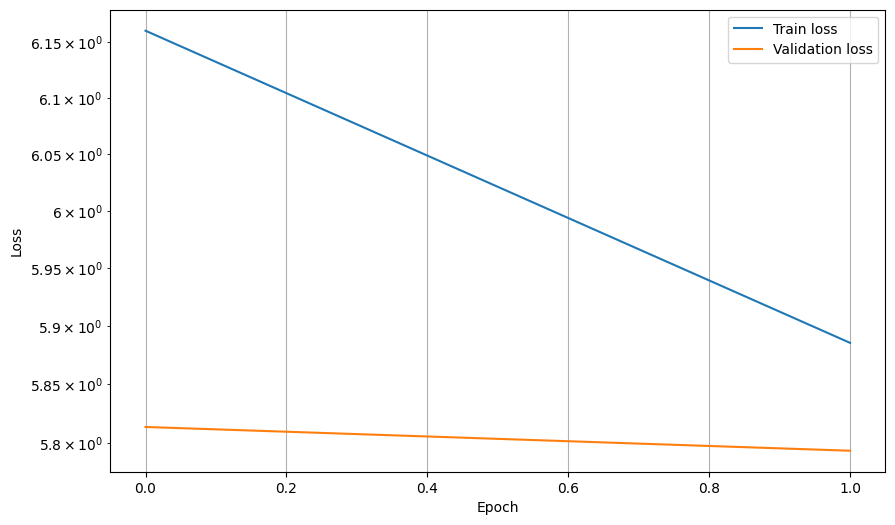

In [30]:
plot_losses(train_loss_log, val_loss_log)

In [31]:
#example
model = ResNet50()
model.load_state_dict(torch.load(volume_dir+"model.pt"))
k_list = [1,2,3,4,5]
topk_accuracy_train = evaluate_network(train_dataloader, model, k_list, "Training Dataset")
topk_accuracy_valid = evaluate_network(valid_dataloader, model, k_list, "Validation Dataset")
topk_accuracy_test = evaluate_network(test_dataloader, model, k_list, "Test Dataset")  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.35it/s]


Training Dataset results:
	top-1 accuracy 0.011
	top-2 accuracy 0.02
	top-3 accuracy 0.03
	top-4 accuracy 0.04
	top-5 accuracy 0.047


 63%|█████████████████████████████████████████████████████████████████████████▊                                           | 157/249 [00:06<00:03, 23.77it/s]


KeyboardInterrupt: 